In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
df = pd.read_csv(r'D:\PIMA\data_2\diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

In [85]:
X = df.drop('Diabetes_binary',axis=1)

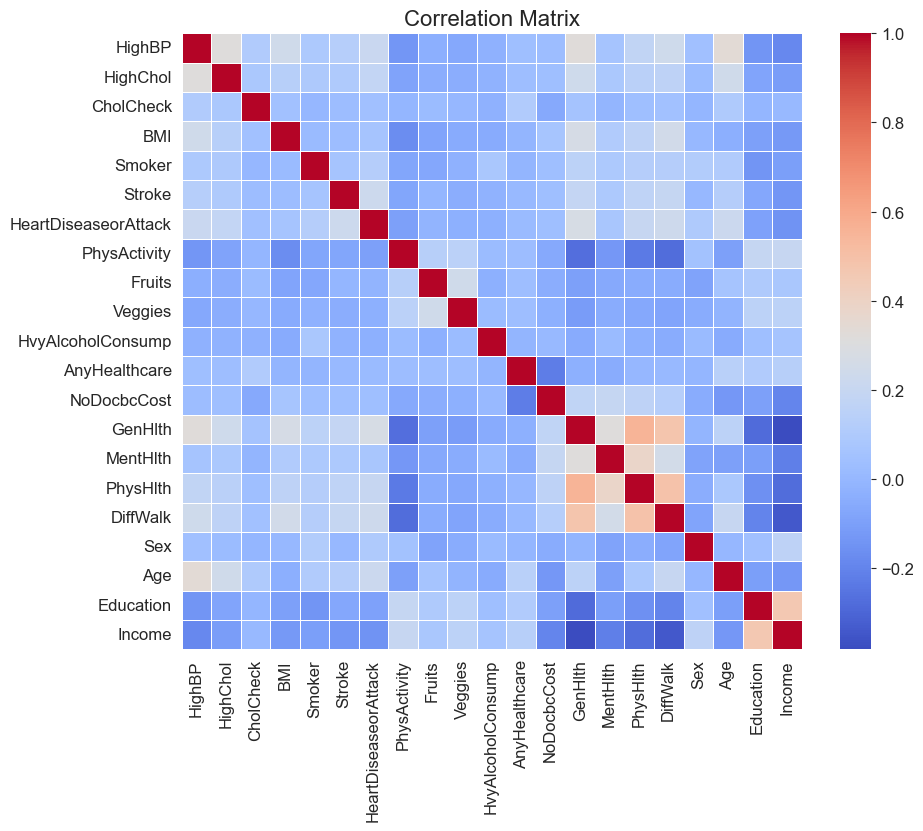

In [86]:
correlation_matrix = X.corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [87]:
def bmi_category(bmi):
    if bmi < 18.5:
        return 1  # Underweight
    elif bmi < 25:
        return 2  # Normal weight
    elif bmi < 30:
        return 3  # Overweight
    elif bmi < 35:
        return 4  # Obese (Class 1)
    elif bmi < 40:
        return 5  # Obese (Class 2)
    else:
        return 6  # Obese (Class 3)

df['BMI'] = df['BMI'].apply(bmi_category)

In [88]:
corr_pairs = correlation_matrix.unstack()

# Drop self-correlations (which are always 1.0)
corr_pairs = corr_pairs[corr_pairs < 1.0]

# Get absolute values for sorting (if you care about strength regardless of direction)
corr_pairs_abs = corr_pairs.abs()

# Sort by correlation value (descending) and get top 10
top_10_correlations = corr_pairs_abs.sort_values(ascending=False)[:10]

# Print the results
for idx, corr in top_10_correlations.items():
    print(f"{idx[0]} & {idx[1]}: {corr_pairs[idx]:.4f}")

GenHlth & PhysHlth: 0.5528
PhysHlth & GenHlth: 0.5528
DiffWalk & PhysHlth: 0.4880
PhysHlth & DiffWalk: 0.4880
GenHlth & DiffWalk: 0.4766
DiffWalk & GenHlth: 0.4766
Income & Education: 0.4606
Education & Income: 0.4606
GenHlth & Income: -0.3830
Income & GenHlth: -0.3830


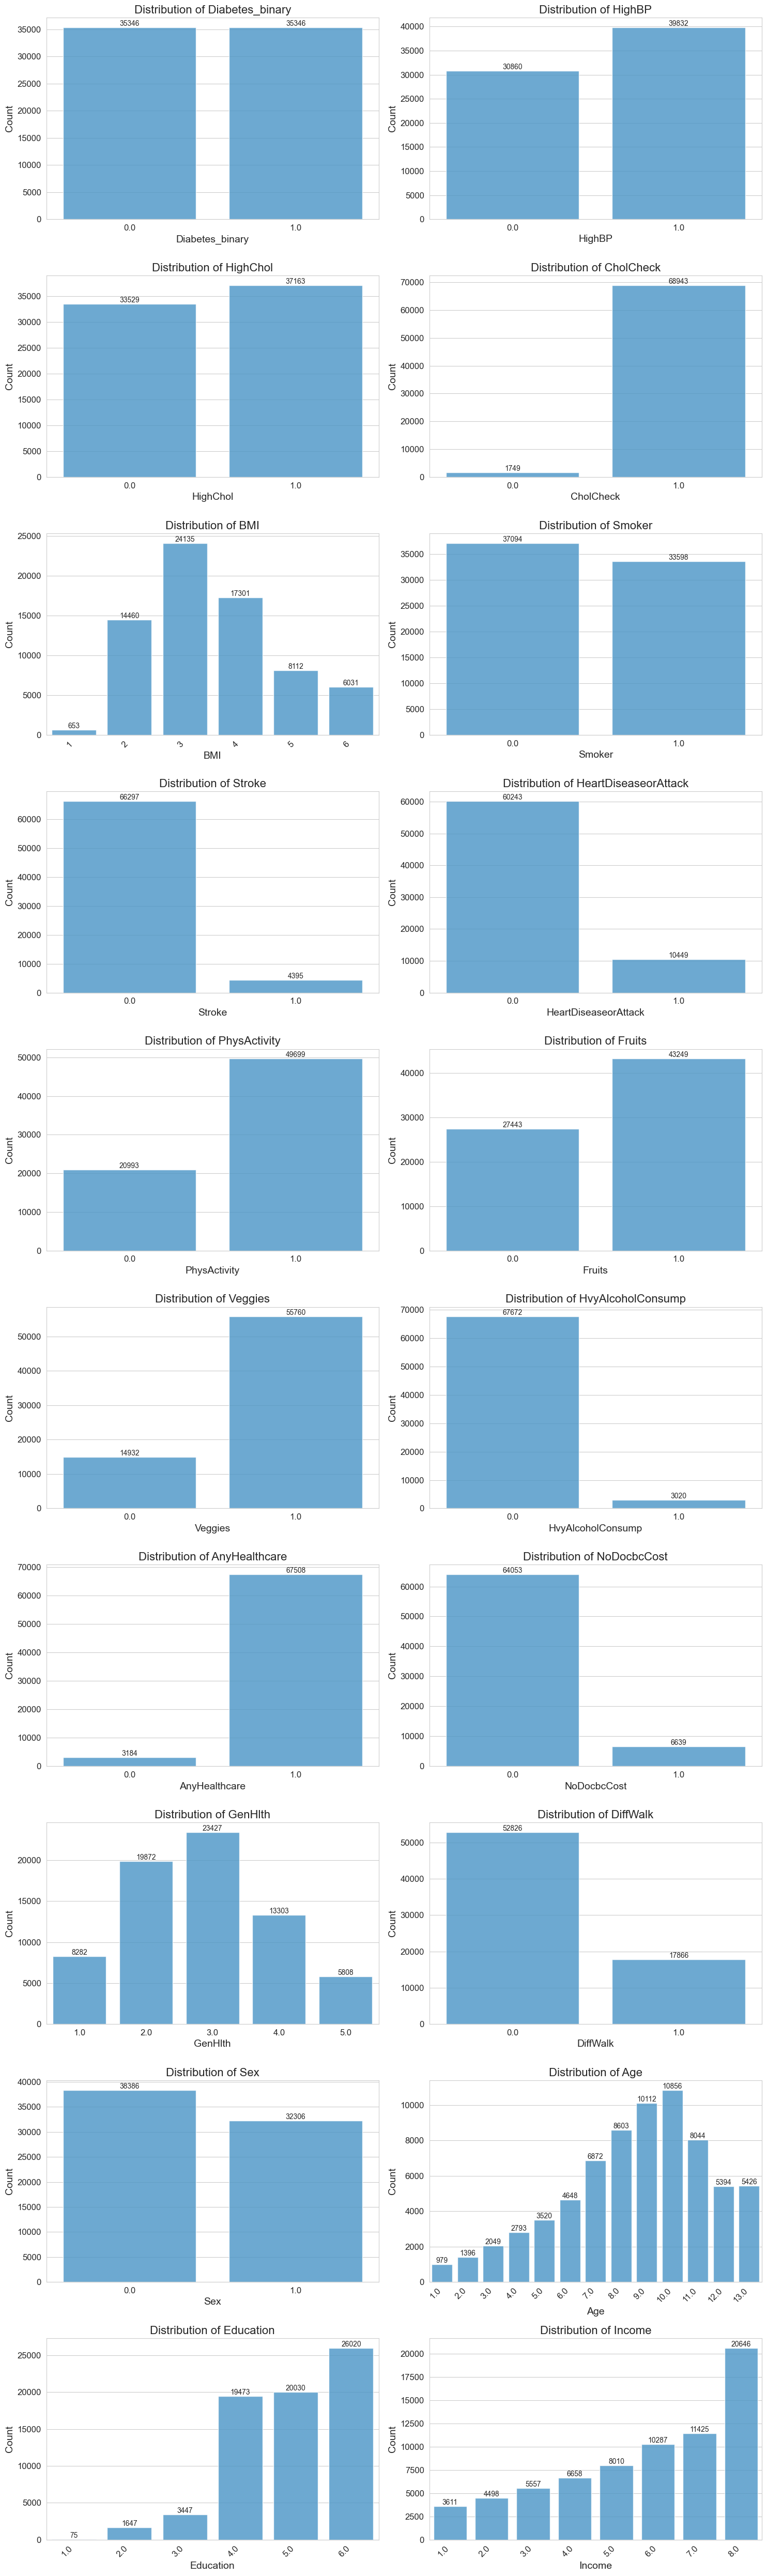

In [89]:
import matplotlib as mpl
# Set the style for the plots
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12, 'axes.labelsize': 14, 'axes.titlesize': 16})

# Custom color palette - you can change these colors
colors = ["#3498db", "#2ecc71", "#9b59b6", "#e74c3c", "#f39c12", "#1abc9c"]
custom_palette = sns.color_palette(colors)
sns.set_palette(custom_palette)

# Function to create countplots for all features
def plot_countplots(df, figsize=(15, 50), max_unique=20):
    # Get categorical and numeric columns that have few unique values
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    # Filter numeric columns with a reasonable number of unique values
    plot_cols = list(categorical_cols)
    for col in numeric_cols:
        if df[col].nunique() <= max_unique:
            plot_cols.append(col)
    
    if not plot_cols:
        print("No suitable columns found for countplots.")
        return
        
    # Calculate number of rows and columns for subplots
    n_cols = 2
    n_rows = int(np.ceil(len(plot_cols) / n_cols))
    
    # Create the figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    # Create a countplot for each suitable column
    for i, col in enumerate(plot_cols):
        if i < len(axes):
            sns.countplot(x=col, data=df, ax=axes[i], alpha=0.8)
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Count')
            
            # Rotate x-axis labels if there are many categories
            if df[col].nunique() > 5:
                plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')
                
            # Add count labels on top of bars
            for p in axes[i].patches:
                axes[i].annotate(f'{int(p.get_height())}', 
                                (p.get_x() + p.get_width()/2., p.get_height()),
                                ha='center', va='bottom', fontsize=10)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

plot_countplots(df)


In [90]:
from scipy.stats import pointbiserialr, spearmanr
from sklearn.feature_selection import mutual_info_classif

target_column = 'Diabetes_binary'
target = df[target_column]

# Dictionary to store correlation results
correlations = {}

# Process each feature based on its type
for column in df.columns:
    if column == target_column:
        continue
        
    # Count unique values
    n_unique = df[column].nunique()
    
    # For binary features (0/1)
    if n_unique == 2:
        # Phi coefficient (equivalent to Pearson for two binary variables)
        corr, _ = pointbiserialr(df[column], target)
        correlations[column] = {'method': 'phi/pointbiserial', 'score': corr}
    
    # For ordinal features with few categories
    elif n_unique <= 10:
        # Spearman rank correlation
        corr, _ = spearmanr(df[column], target)
        correlations[column] = {'method': 'spearman', 'score': corr}
    
    # For continuous features
    else:
        # Point-biserial (equivalent to Pearson when one variable is binary)
        corr, _ = pointbiserialr(df[column], target)
        correlations[column] = {'method': 'pointbiserial', 'score': corr}

# Convert to DataFrame and sort
corr_df = pd.DataFrame.from_dict(correlations, orient='index')
corr_df = corr_df.sort_values('score', ascending=False, key=abs)

# For non-linear relationships (for all features)
mi_scores = mutual_info_classif(df.drop(target_column, axis=1), target)
mi_df = pd.DataFrame({'Feature': df.drop(target_column, axis=1).columns, 
                     'MI_Score': mi_scores})
mi_df = mi_df.sort_values('MI_Score', ascending=False)

# Print both results
print("Linear correlations:")
print(corr_df)
print("\nMutual Information (captures non-linear relationships):")
print(mi_df)

Linear correlations:
                                 method     score
GenHlth                        spearman  0.414259
HighBP                phi/pointbiserial  0.381516
BMI                            spearman  0.315584
HighChol              phi/pointbiserial  0.289213
Age                       pointbiserial  0.278738
DiffWalk              phi/pointbiserial  0.272646
Income                         spearman -0.232529
PhysHlth                  pointbiserial  0.213081
HeartDiseaseorAttack  phi/pointbiserial  0.211523
Education                      spearman -0.169926
PhysActivity          phi/pointbiserial -0.158666
Stroke                phi/pointbiserial  0.125427
CholCheck             phi/pointbiserial  0.115382
HvyAlcoholConsump     phi/pointbiserial -0.094853
MentHlth                  pointbiserial  0.087029
Smoker                phi/pointbiserial  0.085999
Veggies               phi/pointbiserial -0.079293
Fruits                phi/pointbiserial -0.054077
Sex                   phi/poi

In [91]:
# Creating Interaction Features:
df['BMI_X_Age'] = df['BMI'] * df['Age']
df['HighBP_X_HighChol'] = df['HighBP'] * df['HighChol']
df['GenHlth_X_PhysHlth'] = df['GenHlth'] * df['PhysHlth']
df['BMI_X_PhysActivity'] = df['BMI'] * df['PhysActivity']
df['Age_X_HighBP'] = df['Age'] * df['HighBP']
df['Income_X_Education'] = df['Income'] * df['Education']
df['Age_X_DiffWalk'] = df['Age'] * df['DiffWalk']
df['health_bp_decay'] = df['GenHlth'] * np.exp(-df['HighBP'])


In [92]:
# Advanced Features


# Socioeconomic status
df['low_ses'] = ((df['Income'] <= 3) & (df['Education'] <= 3)).astype(int)

# Count of pre-existing conditions
condition_cols = ['HighBP', 'HighChol', 'Stroke', 'HeartDiseaseorAttack', 'DiffWalk']
df['condition_count'] = df[condition_cols].sum(axis=1)

from sklearn.cluster import KMeans

# Create a health cluster
kmeans = KMeans(n_clusters=4, random_state=42)
df['health_cluster'] = kmeans.fit_predict(df[['GenHlth', 'PhysHlth', 'MentHlth']])

# Multiplicative risk score with calibration parameters
k_age = 0.01  # Scaling factor for age (per year)
k_bp = 0.5    # Effect multiplier for high blood pressure
k_chol = 0.5  # Effect multiplier for high cholesterol

df['risk_score_mult'] = (
    df['BMI'] * 
    (1 + k_age * df['Age']) * 
    (1 + k_bp * df['HighBP']) * 
    (1 + k_chol * df['HighChol'])
)

<Axes: xlabel='BMI', ylabel='Count'>

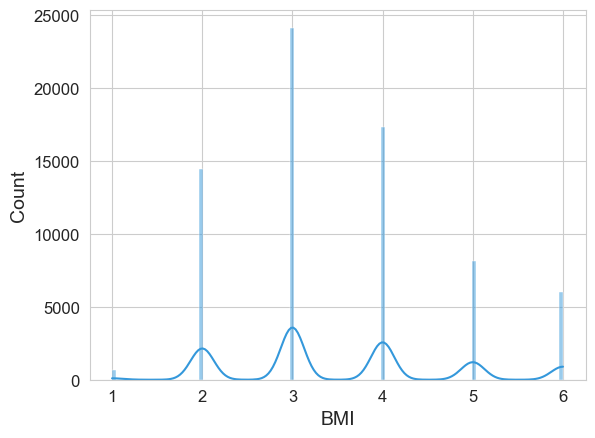

In [93]:
sns.histplot(df['BMI'],kde=True)

In [94]:
df.shape

(70692, 34)

In [95]:
for column in df.columns:
    print(f"{column}:{df[column].nunique()}")

Diabetes_binary:2
HighBP:2
HighChol:2
CholCheck:2
BMI:6
Smoker:2
Stroke:2
HeartDiseaseorAttack:2
PhysActivity:2
Fruits:2
Veggies:2
HvyAlcoholConsump:2
AnyHealthcare:2
NoDocbcCost:2
GenHlth:5
MentHlth:31
PhysHlth:31
DiffWalk:2
Sex:2
Age:13
Education:6
Income:8
BMI_X_Age:45
HighBP_X_HighChol:2
GenHlth_X_PhysHlth:87
BMI_X_PhysActivity:7
Age_X_HighBP:14
Income_X_Education:27
Age_X_DiffWalk:14
health_bp_decay:10
low_ses:2
condition_count:6
health_cluster:4
risk_score_mult:179


In [96]:
df['MentHlth'].unique()

array([ 5.,  0.,  7.,  3.,  4.,  2., 30., 20.,  1., 15., 10., 25., 14.,
       28.,  6., 29., 26., 12., 16., 22., 13.,  8.,  9., 21., 18., 17.,
       27., 24., 23., 11., 19.])

In [97]:
df.to_csv(r'D:\PIMA\data_2\cleaned_1.csv')